Importing all necessary libraries along with the location of the dataset.

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_location = '~/Desktop/cleanedFraudData.csv'

Retrieving the CSV file and reading it.

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(data_location)

The next two cells show the data imbalance as a pie chart and in a numerical format. Seeing as less than 0.5% of transactions are fraudulent, an oversampling technique will need to be used in order to create an accurate model.

<Axes: ylabel='count'>

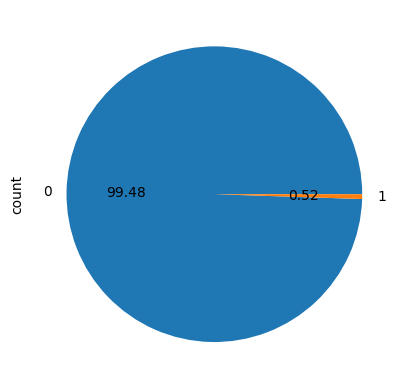

In [3]:
df['is_fraud'].value_counts().plot.pie(autopct = '%.2f')

In [4]:
df['is_fraud'].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

The fraud column is dropped and stored in the y variable. This is done so that the features are stored in the X variable, and the is_fraud variable is stored elsewhere.

In [5]:
X = df.drop(['is_fraud'], axis = 1)
y = df['is_fraud']

The dataset is split so that 80% of it is used for training, and the rest is used to test the model.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The SMOTE oversampling technique is used to generate enough data samples to train an accurate model. In short, synthetic data is generated using a KNN data algorithm, which allows the model to train using more data samples.

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

After SMOTE is applied, note that there are an equal amount of fraud and non-fraud "transactions" in the dataset. 

In [8]:
y_train.value_counts()

is_fraud
0    1474137
1    1474137
Name: count, dtype: int64

The Python XGBoost library stores datasets as a DMatrix class. The training data is transformed into the appropriate type to be analyzed using XGBoost.

In [9]:
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

Since transactions are either marked as fraudulent or legitimate, this is a binary classification problem, and the objective in the parameters is set to binary logistic regression. The model is trained using these parameters, and it continues to train itself unless it doesn't improve in 50 rounds of boosting (early_stopping_rounds = 50).

In [10]:
params = {"objective": "binary:logistic"}

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=1000,
   evals=evals,
   verbose_eval=25,
   early_stopping_rounds=50
)

[0]	train-logloss:0.47896	validation-logloss:0.47879
[25]	train-logloss:0.07808	validation-logloss:0.08903
[50]	train-logloss:0.07015	validation-logloss:0.08179
[75]	train-logloss:0.06650	validation-logloss:0.07844
[100]	train-logloss:0.06459	validation-logloss:0.07668
[125]	train-logloss:0.06302	validation-logloss:0.07535
[150]	train-logloss:0.06186	validation-logloss:0.07448
[175]	train-logloss:0.06121	validation-logloss:0.07395
[200]	train-logloss:0.06065	validation-logloss:0.07352
[225]	train-logloss:0.06012	validation-logloss:0.07317
[250]	train-logloss:0.05975	validation-logloss:0.07289
[275]	train-logloss:0.05944	validation-logloss:0.07261
[300]	train-logloss:0.05916	validation-logloss:0.07244
[325]	train-logloss:0.05896	validation-logloss:0.07235
[350]	train-logloss:0.05878	validation-logloss:0.07225
[375]	train-logloss:0.05862	validation-logloss:0.07221
[400]	train-logloss:0.05848	validation-logloss:0.07214
[425]	train-logloss:0.05834	validation-logloss:0.07206
[450]	train-log

The model is now cross validated to test its accuracy. The same parameters from before are used. XGBoost will stop itself at some amount of boosting rounds (usually anywhere from 350 to 650) in order to maximize performance without running the risk of overfitting. Normally, one would find how many rounds it takes to maximize performance and set the number of boosting rounds to that amount. In this instance, it is set to 550 for illustrative purposes and to speed up evaluation. 

In [11]:
results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=550,
   nfold=3,
   metrics=['aucpr']
)

results['test-aucpr-mean'].max()

0.9972584556413437

The screenshot below shows an illustration of what happens when the ML model is trained without preprocessing the data using an oversampling method. Note the suspiciously low validation log-loss of 0.00939 compared to 0.07185 as seen above. Calculating the area under the precision recall curve (AUPRC) gives a much lower accuracy of 71.3% without using SMOTE, compared to 99.7% when using SMOTE.

In short, logarithmic loss only measures how much the predicted result diverges from the actual result. When a data set is vastly favoring one value over another, it results in very few instances where "loss" occurs. 

As an thought exercise, consider a doctor that sees cases of acne 99.9% of the time, and melanoma 0.1% of the time. Since most of what she sees is acne, there aren't many cases where she makes a wrong diagnosis, and she can be considered a good doctor in this vaccum (low log loss). Her predictions are generally right, but this does not translate to making an accurate diagnosis - when the melanoma case comes around, she is likely to flag it as acne because that is the vast majority of what she sees (low AUPRC).

In conclusion, it is trivial to have a logarithmic loss close to 0 when the vast majority of data samples (99.4%) are 0 (i.e, not fraud). This issue is exposed using AUPRC, as the few cases of fraud that occur in the dataset (hard negatives) are able to be distinguished from the many cases of legitimate transactions (easy positives).

<img src="XGB Without SMOTE.png" alt="Running XGBoost without oversampling the data."/>

In [26]:
test = np.array([[8, 1335.95, 4, 2]])
model.inplace_predict(test)[0]

0.29270634